## 프로젝트: End-to-End OCR

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr2')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr2


In [46]:
import PIL
import cv2
import keras_ocr
from PIL import Image, ImageDraw

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

from keras_ocr.detection import Detector
HOME_DIR = os.getenv('HOME')+'/aiffel/workplace/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8
Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


## Keras ocr Detector를 활용하여, 이미지 내 문자위치 찾기

In [47]:
def detect_text(img_path):
    # 이미지를 로드하고 keras-ocr의 Detector 입력에 맞게 처리
    img_pil = Image.open(img_path).convert('RGB')  # 이미지를 PIL 이미지로 로드 -> (W,H,C)
    
    # kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img_array = np.array(img_pil)  # NumPy 배열로 변환 (H,W,C)

    # 배치 크기를 위해 dimension을 확장하고,
    img_batch = np.expand_dims(img_array, axis=0) # (1,H,W,C)

    
    # Detector를 사용하여 텍스트 영역 검출
    # 배치의 첫 번째 결과만 가져옵니다. (이미지가 한장이니, 배치크기 1)
    ocr_result = detector.detect(img_batch)[0]  
    
    # 시각화를 위해 이미지를 복사
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img) # ImageDraw 객체를 생성
    
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    # text_result: 감지된 텍스트 영역의 좌표를 저장
    cropped_imgs = []
    for text_result in ocr_result:
        # 텍스트 영역 좌표로 시각화 (폴리곤)
        img_draw.polygon(text_result, outline='red') #img_draw=복사된 result_img에 폴리곤 그리기
        
        # 텍스트 영역 좌표를 바운딩 박스로 변환 +-5로 충분히 감싸도록
        x_min = text_result[:, 0].min() - 5 
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]

        # 바운딩 박스에 해당하는 이미지를 자르기
        cropped_imgs.append(img_pil.crop(word_box))
        # img_pill.crop : 이미지에서 지정된 사각형 영역 잘라 반환

    return result_img, cropped_imgs
# result img : 폴리곤이 그려진 상태로 나옴 
# cropped_img : 잘라낸 텍스트 영역 이미지 (추후 recognition에서 사용?)

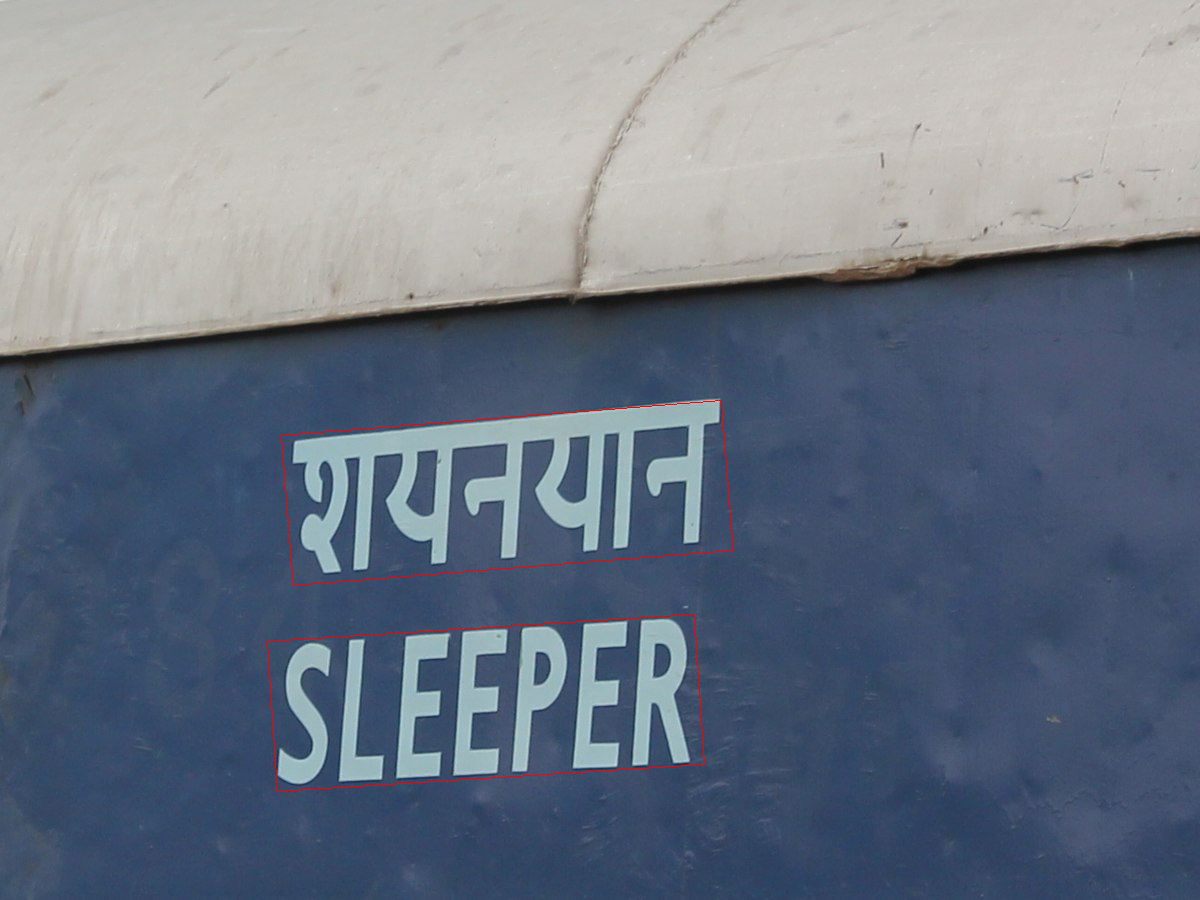

In [48]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

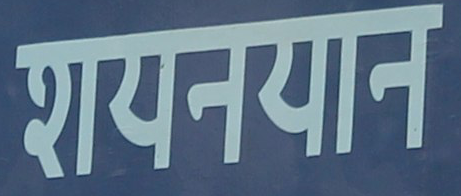

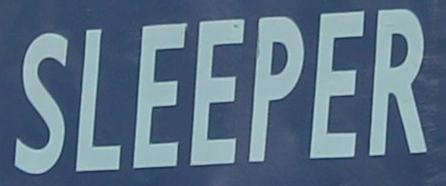

In [50]:
display(cropped_img[0])
display(cropped_img[1])

## Recognize model로 detectioned img 인식 및 출력하기

In [51]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # 모델 예측
    output = model_pred.predict(np.expand_dims(np.array(pil_img.resize((100, 32), 3)).transpose(1, 0, 2), axis=0))
    
    # CTC 디코딩 결과
    result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0].replace('-', '')
    print(f"Result: \t", result)
    display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))
    

Result: 	 VUPRUA999999999999999999


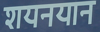

Result: 	 SLEEPER9999999999999999


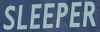

In [52]:
for _img in cropped_img:
    recognize_img(_img)

## 적용해보기

### 1. Medical record ocr 실험(eng)

In [68]:
IMG_PATH_medical_record = '/aiffel/aiffel/ocr2/medicla_record.png'

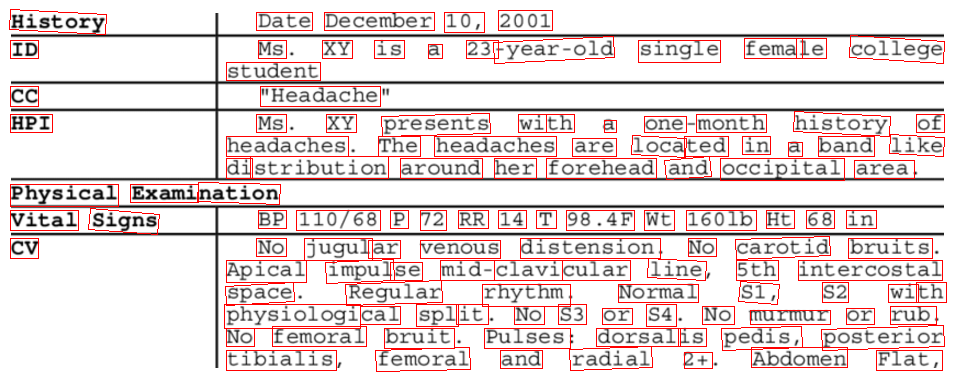

In [69]:
img_pil1, cropped_img1 = detect_text(IMG_PATH_medical_record)
display(img_pil1)

- 텍스트에서 일부 누락된 텍스트들이 보입니다. 이는 주로 . " 과 같은 문자기호로 보입니다. 이외의 텍스트들은 잘 감지되었습니다.
- ID칸의 female영역이 두부분으로 나뉘어 감지되었습니다. CRAFT 알고리즘이 기반인 keras-ocr detector임을 감안했을때, 문자간 연결성을 체크해주는 affinity box및 score가 잘 이뤄지지 않았다고 생각합니다. 이는 다른 문자에 비해 a와 l사이의 간격이 넓거나 연결성이 부족하여 계산되었을 가능성이 있다고 생각합니다.
- 이런 유사한 오류를 제외하고는, 다른 문자들에 대해선 '단어기준' 어느정도 감지가 되었다고 생각합니다.
- 하지만, 성능기준으로 보았을때 위 모델은 고객에게 배포되기 어렵다고 생각합니다.


Result: 	 2OZ999999999999999999999


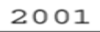

Result: 	 HISTORY99999999999999999


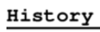

Result: 	 DATE99999999999999999999


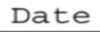

Result: 	 DECEMBER9999999999999999


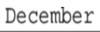

Result: 	 JLOER9999999999999999999


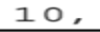

Result: 	 PLYEAPROIA99999999999999


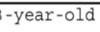

Result: 	 FEMAD9999999999999999999


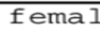

Result: 	 SOLES9999999999999999999


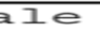

Result: 	 SEONEGE99999999999999999


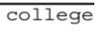

Result: 	 SRS999999999999999999999


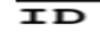

Result: 	 SIMIS9999999999999999999


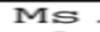

Result: 	 XH9999999999999999999999


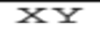

Result: 	 WLS999999999999999999999


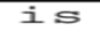

Result: 	 ZS9999999999999999999999


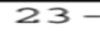

Result: 	 SINGLE999999999999999999


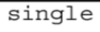

Result: 	 SLES99999999999999999999


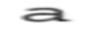

Result: 	 STUDENT99999999999999999


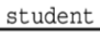

Result: 	 WA9999999999999999999999


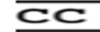

Result: 	 NHEADACHE999999999999999


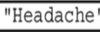

Result: 	 YFET99999999999999999999


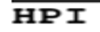

Result: 	 HIMS99999999999999999999


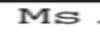

Result: 	 CN9999999999999999999999


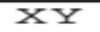

Result: 	 PRESENTS9999999999999999


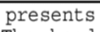

Result: 	 ASLS99999999999999999999


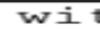

Result: 	 PEY999999999999999999999


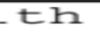

Result: 	 RMONEH999999999999999999


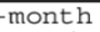

Result: 	 SHISRORY9999999999999999


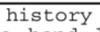

Result: 	 WOE999999999999999999999


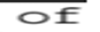

Result: 	 YONES9999999999999999999


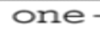

Result: 	 SES999999999999999999999


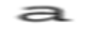

Result: 	 HEADACHES999999999999999


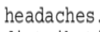

Result: 	 SPHE99999999999999999999


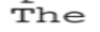

Result: 	 HEADACHES999999999999999


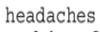

Result: 	 JOCAT9999999999999999999


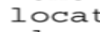

Result: 	 ACEA99999999999999999999


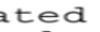

Result: 	 RLS999999999999999999999


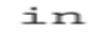

Result: 	 BANA99999999999999999999


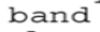

Result: 	 LIKE99999999999999999999


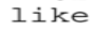

Result: 	 SATE99999999999999999999


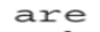

Result: 	 AEAES9999999999999999999


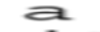

Result: 	 LSTRIBUTION9999999999999


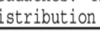

Result: 	 PAIAS9999999999999999999


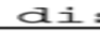

Result: 	 AROUND999999999999999999


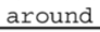

Result: 	 HERS99999999999999999999


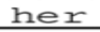

Result: 	 FOREHEAD9999999999999999


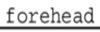

Result: 	 SANA99999999999999999999


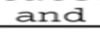

Result: 	 OCIPITAL9999999999999999


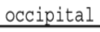

Result: 	 AREAS9999999999999999999


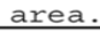

Result: 	 PHYSICAL9999999999999999


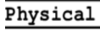

Result: 	 EXAMIS999999999999999999


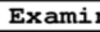

Result: 	 SNATION99999999999999999


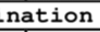

Result: 	 VIEAL999999999999999999


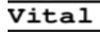

Result: 	 SAGNS9999999999999999999


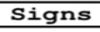

Result: 	 WES999999999999999999999


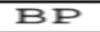

Result: 	 OVGE99999999999999999999


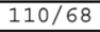

Result: 	 WASTE9999999999999999999


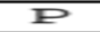

Result: 	 ZEN999999999999999999999


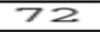

Result: 	 WRE999999999999999999999


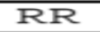

Result: 	 HLN999999999999999999999


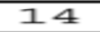

Result: 	 WOCEN9999999999999999999


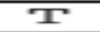

Result: 	 SERAF9999999999999999999


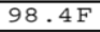

Result: 	 JVTA99999999999999999999


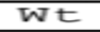

Result: 	 IGOIS9999999999999999999


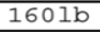

Result: 	 PIEN99999999999999999999


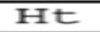

Result: 	 HSH999999999999999999999


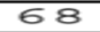

Result: 	 WLIE99999999999999999999


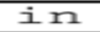

Result: 	 ST9999999999999999999999


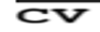

Result: 	 JIA999999999999999999999


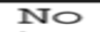

Result: 	 JUGUNE999999999999999999


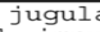

Result: 	 DISTENSIONS9999999999999


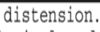

Result: 	 JIA999999999999999999999


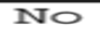

Result: 	 CAROTID99999999999999999


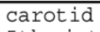

Result: 	 BRUIES999999999999999999


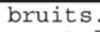

Result: 	 LAS999999999999999999999


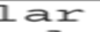

Result: 	 VENOUS999999999999999999


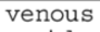

Result: 	 APICAL999999999999999999


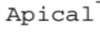

Result: 	 YIMPULS99999999999999999


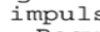

Result: 	 MIAS99999999999999999999


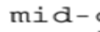

Result: 	 SELAVIE99999999999999999


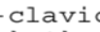

Result: 	 SCULAR999999999999999999


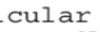

Result: 	 SLINES999999999999999999


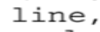

Result: 	 YSCH99999999999999999999


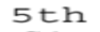

Result: 	 INTERCOSTAL9999999999999


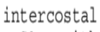

Result: 	 LS9999999999999999999999


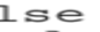

Result: 	 REGULAR99999999999999999


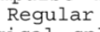

Result: 	 YSIA99999999999999999999


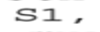

Result: 	 SA9999999999999999999999


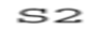

Result: 	 SES999999999999999999999


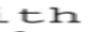

Result: 	 SPACE9999999999999999999


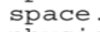

Result: 	 RHYTHMA99999999999999999


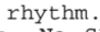

Result: 	 NORMAL999999999999999999


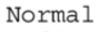

Result: 	 AYIET9999999999999999999


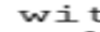

Result: 	 PHYSIOLOGI99999999999999


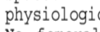

Result: 	 ESPLS9999999999999999999


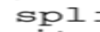

Result: 	 VIAERS99999999999999999


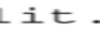

Result: 	 ASA999999999999999999999


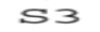

Result: 	 SES999999999999999999999


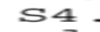

Result: 	 SCAD99999999999999999999


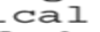

Result: 	 LNS999999999999999999999


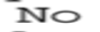

Result: 	 MNES99999999999999999999


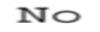

Result: 	 YUS999999999999999999999


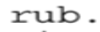

Result: 	 AS9999999999999999999999


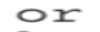

Result: 	 MURMUR999999999999999999


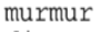

Result: 	 OS9999999999999999999999


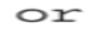

Result: 	 FEMORAL99999999999999999


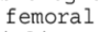

Result: 	 MIES99999999999999999999


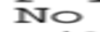

Result: 	 BRUIS9999999999999999999


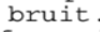

Result: 	 PULSES999999999999999999


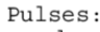

Result: 	 DORSALS99999999999999999


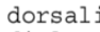

Result: 	 PLS999999999999999999999


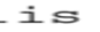

Result: 	 PEDIS9999999999999999999


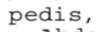

Result: 	 POSTERIOR999999999999999


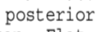

Result: 	 FEMORAL99999999999999999


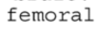

Result: 	 RADIAL999999999999999999


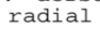

Result: 	 ABDOMEN99999999999999999


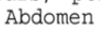

Result: 	 TIBIALIS9999999999999999


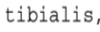

Result: 	 SAND99999999999999999999


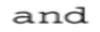

Result: 	 SPAS99999999999999999999


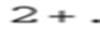

Result: 	 FLATS9999999999999999999


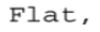

In [70]:
for _img in cropped_img1:
    recognize_img(_img)

### -> 문제점 개선 실험 : link_threshold 조정 (detector의 threshold를 조정하여, 결과를 비교해보려 합니다)
detector.detect(images, text_threshold=, link_threshold=)
- text_threshold 의 값을 높이면, 텍스트로 인식되는 영역이 더 엄격하게 제한됩니다.  
    -> 작은 텍스트 혹은 불명확한 텍스트는 누락될 가능성이 있음
- link_threshold 의 값으 높이면 텍스트 간 연결성이 엄격하게 평가됩니다.  
    -> 텍스트 간 간격이 조금만 넓더라도 다른 영역으로 분리될 가능성이 높아짐

In [97]:
def detect_text(img_path, text_threshold=0.7, link_threshold=0.4): 
    # 이미지를 로드하고 keras-ocr의 Detector 입력에 맞게 처리
    img_pil = Image.open(img_path).convert('RGB')  # 이미지를 PIL 이미지로 로드 -> (W,H,C)
    img_array = np.array(img_pil)  # NumPy 배열로 변환 (H,W,C)
    img_batch = np.expand_dims(img_array, axis=0)  # 배치 차원 추가 (1,H,W,C)

    # Detector를 사용하여 텍스트 영역 검출
    ocr_result = detector.detect(
        images=img_batch, 
        text_threshold=text_threshold, 
        link_threshold=link_threshold
    )[0]  # 배치의 첫 번째 결과만 가져옴

    # 시각화를 위해 이미지를 복사
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)  # ImageDraw 객체 생성

    # 감지된 텍스트 영역을 기반으로 시각화 및 텍스트 영역 크롭
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')  # 폴리곤 그리기
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]

        # 바운딩 박스에 해당하는 이미지를 자르기
        cropped_imgs.append(img_pil.crop(word_box))

    return result_img, cropped_imgs

#### -1. text_threshold 0.7, link_threshold 0.4
- a, P, T, 2+ 등과 같이 단일 문자를 감지하지 못하는 경우가 보입니다.  
    이는, 위 영역의 픽셀들에 대해 텍스트가 아니라고 확률적으로 예측한 결과라고 생각합니다. a나 P라는 단어는 그 단어 옆에 오로지 흰바탕만 존재하게 되며, receptive field를 기준으로 해당 텍스트의 픽셀 크기가 너무 작을시 이를 무시할수 있다고 합니다.
    -> 실제 두글자 이상의 문자는 width가 30 이상이지만, a의 width는 22입니다.
    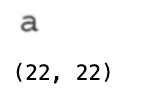  
    혹은, 두글자 이상의 문자는 affinity score또한 단어 감지에 영향을 미치므로, 이 또한 단일 문자와의 차이를 발생시킨다고 생각합니다.
- 여전히 ID행 기준, female을 fema, le로 연결지어 감지하지 못하고 있습니다.

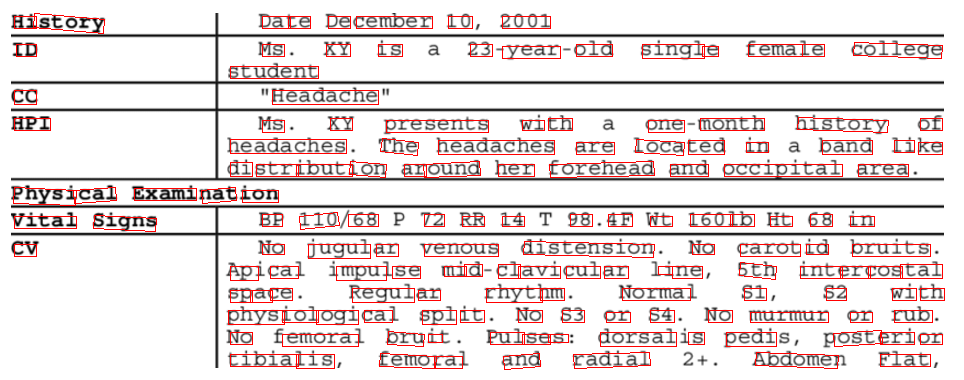

In [98]:
img_pil1, cropped_img1 = detect_text(IMG_PATH_medical_record)
display(img_pil1)

In [103]:
display(cropped_img1[10])
print(cropped_img1[10].size) # W, H
display(cropped_img1[12])
print(cropped_img1[12].size) # W, H

(34, 22)


(32, 22)


#### -2. text_threshold 0.5, link_threshold 0.2
- text_threshold를 낮추니, a, P, T, 2+ 등과 같이 단일 문자를 감지할수 있게 됐습니다.
        -> 픽셀이 텍스트로 간주될 확률이 높아져, 단일 문자 또한 감지
- link_threshold 또한 0.2로 낮추니, feamle을 한 단어로 감지할 수 있게 됐습니다.
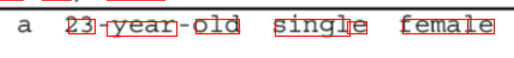
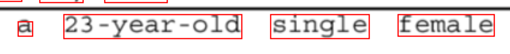

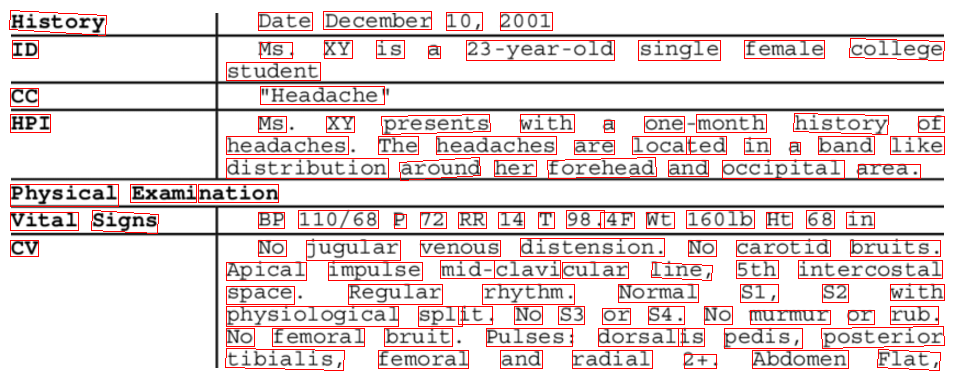

In [104]:
def detect_text(img_path, text_threshold=0.5, link_threshold=0.2): 
    # 이미지를 로드하고 keras-ocr의 Detector 입력에 맞게 처리
    img_pil = Image.open(img_path).convert('RGB')  # 이미지를 PIL 이미지로 로드 -> (W,H,C)
    img_array = np.array(img_pil)  # NumPy 배열로 변환 (H,W,C)
    img_batch = np.expand_dims(img_array, axis=0)  # 배치 차원 추가 (1,H,W,C)

    # Detector를 사용하여 텍스트 영역 검출
    ocr_result = detector.detect(
        images=img_batch, 
        text_threshold=text_threshold, 
        link_threshold=link_threshold
    )[0]  # 배치의 첫 번째 결과만 가져옴

    # 시각화를 위해 이미지를 복사
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)  # ImageDraw 객체 생성

    # 감지된 텍스트 영역을 기반으로 시각화 및 텍스트 영역 크롭
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')  # 폴리곤 그리기
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]

        # 바운딩 박스에 해당하는 이미지를 자르기
        cropped_imgs.append(img_pil.crop(word_box))

    return result_img, cropped_imgs

img_pil1_2, cropped_img1_2 = detect_text(IMG_PATH_medical_record)
display(img_pil1_2)

In [118]:
display(cropped_img1_2[13])
print(cropped_img1_2[13].size) # W, H 22, 22
display(cropped_img1_2[21])
print(cropped_img1_2[21].size) # W, H 22, 22

(22, 22)


(36, 26)


Result: 	 HISTORY99999999999999999


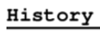

Result: 	 DATE99999999999999999999


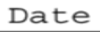

Result: 	 DECEMBER9999999999999999


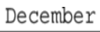

Result: 	 LOS999999999999999999999


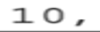

Result: 	 2OD999999999999999999999


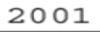

Result: 	 SERS99999999999999999999


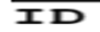

Result: 	 S99999999999999999999999


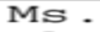

Result: 	 XCE999999999999999999999


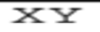

Result: 	 VILS99999999999999999999


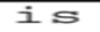

Result: 	 BRYEAROLD999999999999999


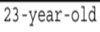

Result: 	 SINGLE999999999999999999


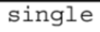

Result: 	 FEMALE999999999999999999


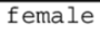

Result: 	 SCOIEGE99999999999999999


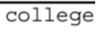

Result: 	 AEAS99999999999999999999


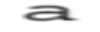

Result: 	 STUDENT99999999999999999


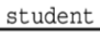

Result: 	 STHEADACHER9999999999999


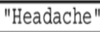

Result: 	 AE9999999999999999999999


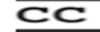

Result: 	 SFET99999999999999999999


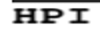

Result: 	 WIEH99999999999999999999


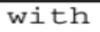

Result: 	 RMONEH999999999999999999


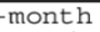

Result: 	 HISTORY99999999999999999


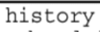

Result: 	 YSER99999999999999999999


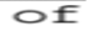

Result: 	 S99999999999999999999999


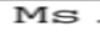

Result: 	 XP9999999999999999999999


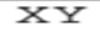

Result: 	 PRESENTS9999999999999999


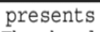

Result: 	 YONES9999999999999999999


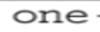

Result: 	 SEAS99999999999999999999


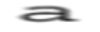

Result: 	 HEADACHES999999999999999


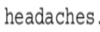

Result: 	 STHE99999999999999999999


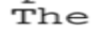

Result: 	 HEADACHES999999999999999


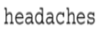

Result: 	 LOCAT9999999999999999999


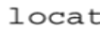

Result: 	 PLED99999999999999999999


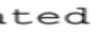

Result: 	 BAND99999999999999999999


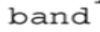

Result: 	 LIKE99999999999999999999


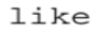

Result: 	 ILS999999999999999999999


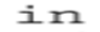

Result: 	 YAXE99999999999999999999


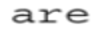

Result: 	 SAES99999999999999999999


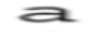

Result: 	 DISTRIBUTION999999999999


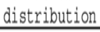

Result: 	 AROUND999999999999999999


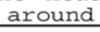

Result: 	 FOREHEAD9999999999999999


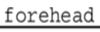

Result: 	 BERS9999999999999999999


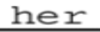

Result: 	 ARA999999999999999999999


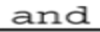

Result: 	 OCIPITAL9999999999999999


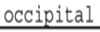

Result: 	 AREAS9999999999999999999


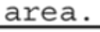

Result: 	 PHYSICAL9999999999999999


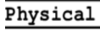

Result: 	 EXAMI9999999999999999999


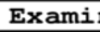

Result: 	 SNATION99999999999999999


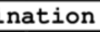

Result: 	 IOGE99999999999999999999


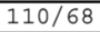

Result: 	 SLE999999999999999999999


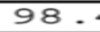

Result: 	 IGOB99999999999999999999


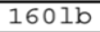

Result: 	 HSH999999999999999999999


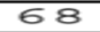

Result: 	 VITAL9999999999999999999


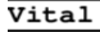

Result: 	 SIGNS9999999999999999999


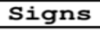

Result: 	 AE9999999999999999999999


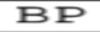

Result: 	 SED999999999999999999999


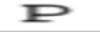

Result: 	 ZE9999999999999999999999


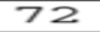

Result: 	 RY9999999999999999999999


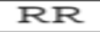

Result: 	 HLA999999999999999999999


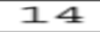

Result: 	 AE9999999999999999999999


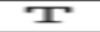

Result: 	 SAP999999999999999999999


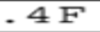

Result: 	 SIUE99999999999999999999


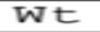

Result: 	 FE9999999999999999999999


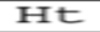

Result: 	 ZS9999999999999999999999


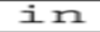

Result: 	 AISTENSION99999999999999


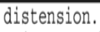

Result: 	 PY9999999999999999999999


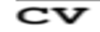

Result: 	 YIS999999999999999999999


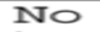

Result: 	 JUGULAR99999999999999999


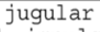

Result: 	 VENOUS999999999999999999


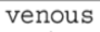

Result: 	 YIES99999999999999999999


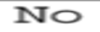

Result: 	 CAROTID99999999999999999


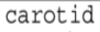

Result: 	 BRUITS999999999999999999


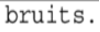

Result: 	 MIAS99999999999999999999


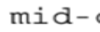

Result: 	 SCLAVI999999999999999999


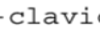

Result: 	 YSCA99999999999999999999


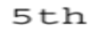

Result: 	 INTERCOSTAL9999999999999


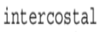

Result: 	 APICAL999999999999999999


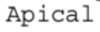

Result: 	 IMPULSE99999999999999999


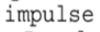

Result: 	 CULAR9999999999999999999


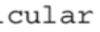

Result: 	 LINES9999999999999999999


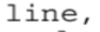

Result: 	 REGULAR99999999999999999


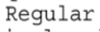

Result: 	 RHYTHMA99999999999999999


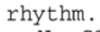

Result: 	 NORMAL999999999999999999


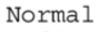

Result: 	 YSA999999999999999999999


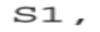

Result: 	 SZE999999999999999999999


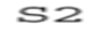

Result: 	 WITH99999999999999999999


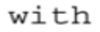

Result: 	 SPACE9999999999999999999


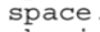

Result: 	 PHYSIOLOGICAL99999999999


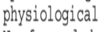

Result: 	 SPLI99999999999999999999


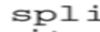

Result: 	 PILES9999999999999999999


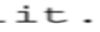

Result: 	 LS9999999999999999999999


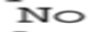

Result: 	 RS9999999999999999999999


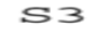

Result: 	 YSA999999999999999999999


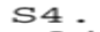

Result: 	 YNS999999999999999999999


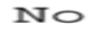

Result: 	 RULBE9999999999999999999


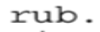

Result: 	 ASOS99999999999999999999


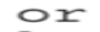

Result: 	 MURMUR999999999999999999


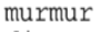

Result: 	 YOAS99999999999999999999


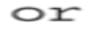

Result: 	 MIES99999999999999999999


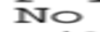

Result: 	 FEMORAL99999999999999999


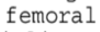

Result: 	 BRUIC9999999999999999999


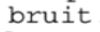

Result: 	 PULSES999999999999999999


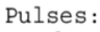

Result: 	 DORSALS99999999999999999


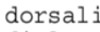

Result: 	 PILS99999999999999999999


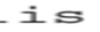

Result: 	 PEDIS9999999999999999999


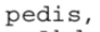

Result: 	 POSTERIOR999999999999999


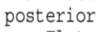

Result: 	 TIBIALIS9999999999999999


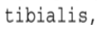

Result: 	 FEMORAL99999999999999999


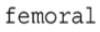

Result: 	 SAND99999999999999999999


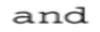

Result: 	 RADIAL999999999999999999


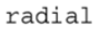

Result: 	 ABDOMEN99999999999999999


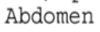

Result: 	 FLACS9999999999999999999


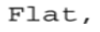

Result: 	 SPATS9999999999999999999


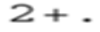

In [119]:
for _img in cropped_img1_2:
    recognize_img(_img)

- 다음으로, cropped img들에 대한, 텍스트 인식 결과 다소 성능이 좋지 않음이 확인됐습니다. 이는 각 박스의 상단에 있는 표의 가로선이 함께 crop되어 인식에 악영향을 미친다고 판단됩니다.
### 문제점 개선 실험 -> box크기 개선
#### -3. polygon y_max = text_result[:, 1].max() + 1


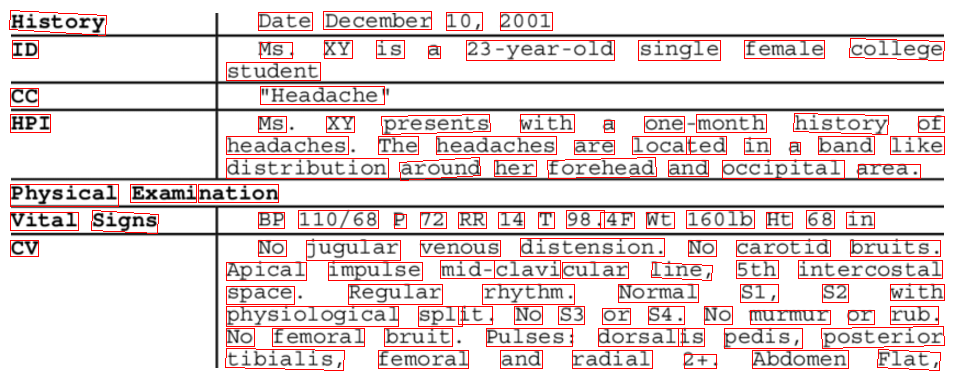

In [121]:
def detect_text(img_path, text_threshold=0.5, link_threshold=0.2): 
    # 이미지를 로드하고 keras-ocr의 Detector 입력에 맞게 처리
    img_pil = Image.open(img_path).convert('RGB')  # 이미지를 PIL 이미지로 로드 -> (W,H,C)
    img_array = np.array(img_pil)  # NumPy 배열로 변환 (H,W,C)
    img_batch = np.expand_dims(img_array, axis=0)  # 배치 차원 추가 (1,H,W,C)

    # Detector를 사용하여 텍스트 영역 검출
    ocr_result = detector.detect(
        images=img_batch, 
        text_threshold=text_threshold, 
        link_threshold=link_threshold
    )[0]  # 배치의 첫 번째 결과만 가져옴

    # 시각화를 위해 이미지를 복사
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)  # ImageDraw 객체 생성

    # 감지된 텍스트 영역을 기반으로 시각화 및 텍스트 영역 크롭
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')  # 폴리곤 그리기
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 1
        y_max = text_result[:, 1].max() + 1
        word_box = [x_min, y_min, x_max, y_max]

        # 바운딩 박스에 해당하는 이미지를 자르기
        cropped_imgs.append(img_pil.crop(word_box))

    return result_img, cropped_imgs

img_pil1_2, cropped_img1_2 = detect_text(IMG_PATH_medical_record)
display(img_pil1_2)

Result: 	 HISTORY99999999999999999


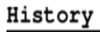

Result: 	 DATE99999999999999999999


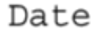

Result: 	 DECEMBER9999999999999999


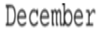

Result: 	 SLOR99999999999999999999


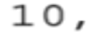

Result: 	 2OI999999999999999999999


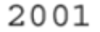

Result: 	 YD9999999999999999999999


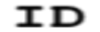

Result: 	 MS9999999999999999999999


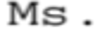

Result: 	 SXP999999999999999999999


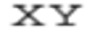

Result: 	 SLS999999999999999999999


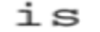

Result: 	 DIEYEAROLD99999999999999


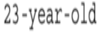

Result: 	 SINGLE999999999999999999


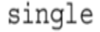

Result: 	 FEMALE999999999999999999


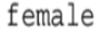

Result: 	 COLLEGE9999999999999999


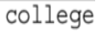

Result: 	 AOLS99999999999999999999


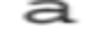

Result: 	 STUDENT99999999999999999


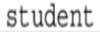

Result: 	 NHEADACHEL99999999999999


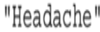

Result: 	 SCE999999999999999999999


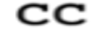

Result: 	 HPT999999999999999999999


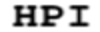

Result: 	 WITH99999999999999999999


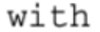

Result: 	 SMONTH999999999999999999


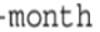

Result: 	 HISTORY99999999999999999


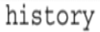

Result: 	 YOT99999999999999999999


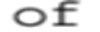

Result: 	 SMIS99999999999999999999


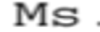

Result: 	 AXY999999999999999999999


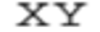

Result: 	 PRESENTS9999999999999999


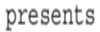

Result: 	 YONE99999999999999999999


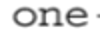

Result: 	 LS9999999999999999999999


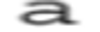

Result: 	 HEADACHES999999999999999


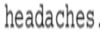

Result: 	 STHE99999999999999999999


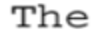

Result: 	 HEADACHES999999999999999


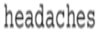

Result: 	 LOCAT9999999999999999999


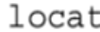

Result: 	 SITED9999999999999999999


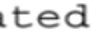

Result: 	 BAND99999999999999999999


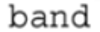

Result: 	 LIKE99999999999999999999


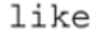

Result: 	 S1P999999999999999999999


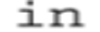

Result: 	 SARE9999999999999999999


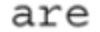

Result: 	 SS999999999999999999999


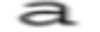

Result: 	 DISTRIBUTION999999999999


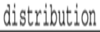

Result: 	 AROUND999999999999999999


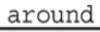

Result: 	 FOREHEAD9999999999999999


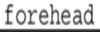

Result: 	 HES999999999999999999999


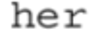

Result: 	 SAND99999999999999999999


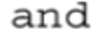

Result: 	 JOCCIPITAL9999999999999


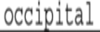

Result: 	 AREAS9999999999999999999


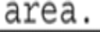

Result: 	 PHYSICAL9999999999999999


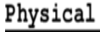

Result: 	 YEXAMI999999999999999999


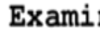

Result: 	 NATION999999999999999999


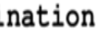

Result: 	 LOGS99999999999999999999


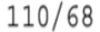

Result: 	 YSBEA9999999999999999999


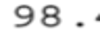

Result: 	 IGOLB9999999999999999999


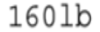

Result: 	 ES9999999999999999999999


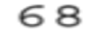

Result: 	 VITAL9999999999999999999


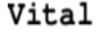

Result: 	 SIGNS9999999999999999999


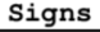

Result: 	 ABP999999999999999999999


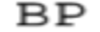

Result: 	 ALSES9999999999999999999


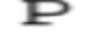

Result: 	 CTEA99999999999999999999


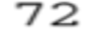

Result: 	 SR9999999999999999999999


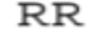

Result: 	 ALS999999999999999999999


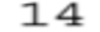

Result: 	 AOTES9999999999999999999


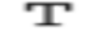

Result: 	 SP9999999999999999999999


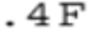

Result: 	 WVE999999999999999999999


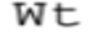

Result: 	 SFE999999999999999999999


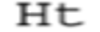

Result: 	 SLA999999999999999999999


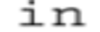

Result: 	 DISTENSIONS9999999999999


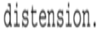

Result: 	 SO9999999999999999999999


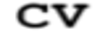

Result: 	 SINE99999999999999999999


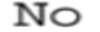

Result: 	 JUGULAR99999999999999999


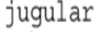

Result: 	 VENOUS999999999999999999


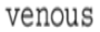

Result: 	 SINE99999999999999999999


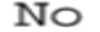

Result: 	 CAROTID99999999999999999


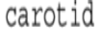

Result: 	 BRUITS999999999999999999


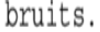

Result: 	 MIDS99999999999999999999


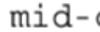

Result: 	 SCLAVI999999999999999999


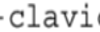

Result: 	 YSH999999999999999999999


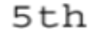

Result: 	 INTERCOSTAL9999999999999


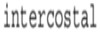

Result: 	 APICAL999999999999999999


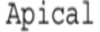

Result: 	 IMPULSE99999999999999999


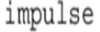

Result: 	 CULAR9999999999999999999


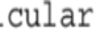

Result: 	 LNER99999999999999999999


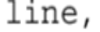

Result: 	 REGULAR99999999999999999


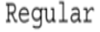

Result: 	 RHYTHMS99999999999999999


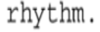

Result: 	 NORMAL999999999999999999


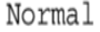

Result: 	 SL1999999999999999999999


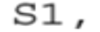

Result: 	 SP9999999999999999999999


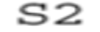

Result: 	 WITH99999999999999999999


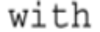

Result: 	 SPACE9999999999999999999


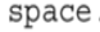

Result: 	 PHYSIOLOGICAL99999999999


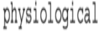

Result: 	 YSPLD9999999999999999999


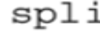

Result: 	 SPIS99999999999999999999


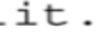

Result: 	 SINE99999999999999999999


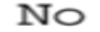

Result: 	 AS9999999999999999999999


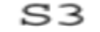

Result: 	 YSA999999999999999999999


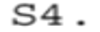

Result: 	 SINE99999999999999999999


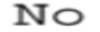

Result: 	 CULBS9999999999999999999


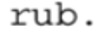

Result: 	 AOA999999999999999999999


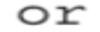

Result: 	 MURMUR999999999999999999


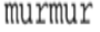

Result: 	 OS9999999999999999999999


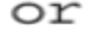

Result: 	 SINE99999999999999999999


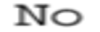

Result: 	 FEMORAL99999999999999999


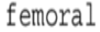

Result: 	 BRUIT9999999999999999999


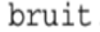

Result: 	 PULSEST99999999999999999


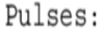

Result: 	 DORSALD99999999999999999


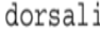

Result: 	 SILS99999999999999999999


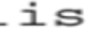

Result: 	 PEDIS9999999999999999999


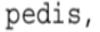

Result: 	 POSTERIOR999999999999999


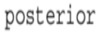

Result: 	 TIBIALIS9999999999999999


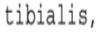

Result: 	 FEMORAL99999999999999999


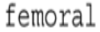

Result: 	 YAND99999999999999999999


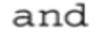

Result: 	 RADIAL999999999999999999


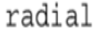

Result: 	 ABDOMEN99999999999999999


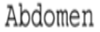

Result: 	 FLATS9999999999999999999


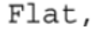

Result: 	 SAHS99999999999999999999


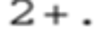

In [122]:
for _img in cropped_img1_2:
    recognize_img(_img)

- box크기 조정 전
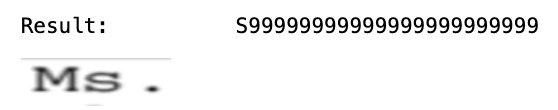
- box크기 조정 후 
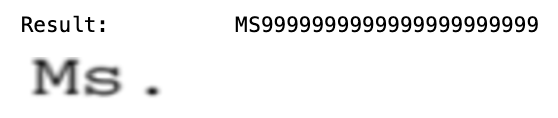

- 추가로, 특수문자 등이 포함된 단어는 문자 인식을 못하는데, 이는 사전에, Target Charcter에 특수문자를 추가하지 않았기 때문입니다.
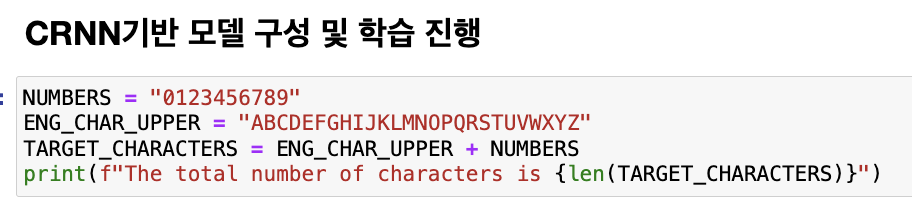
 SPECIAL_CHARACTERS = "!@#$%^&*()_-+=<>?/.,:;'\"[]{}|`~\\"  # 추가할 특수문자  
    TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS + SPECIAL_CHARACTERS  
    -> 이렇게 특수문자를 추가하여 모델 재학습 실험을 진행해보고 싶습니다.


- Recognization 단계를 보았을 때, 4글자 이상의 문자가 모인 단어는 인식이 잘 되나, 한글자 혹은 2글자만으로 이뤄진 단어및 숫자는 결과가 좋지 않았습니다.
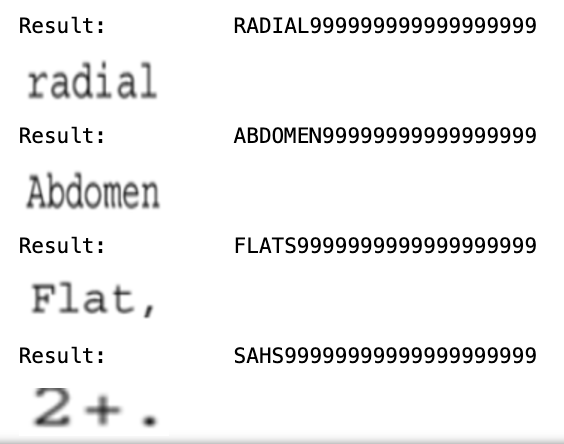
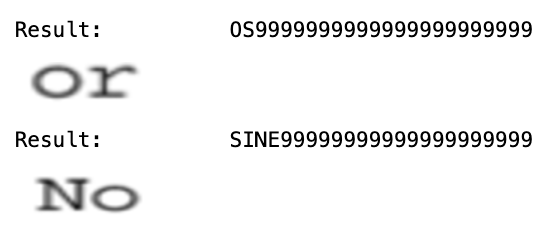
    -> 크기가 작은 영역으로 crop된 후 네트워크 입력 크기로 맞춰들어갈때, 확대가 되는데 이때 노이즈또한 함께 확대되어 텍스트 특징 추출에 악영향을 미칠 것 같습니다. 또한 짧은 단어는 문맥정보 또한 부족하여 예측이 더 어려울 것 같습니다.
    -> 이러한 문제는 ctc디코더를 개선?하면 해결될 수 있다고 생각합니다.

### 2. 의사기준, EMR 차트 ocr 실험_1(eng)

In [126]:
IMG_PATH_emr1 = '/aiffel/aiffel/ocr2/emr_eng1_noise.png'

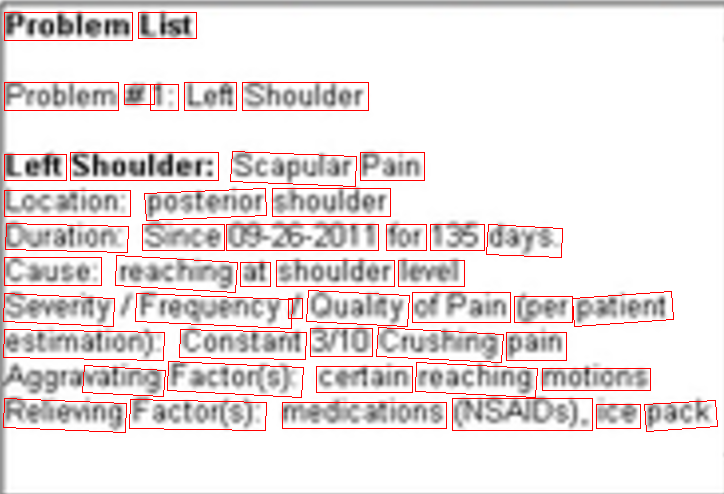

In [127]:
img_pil2, cropped_img2 = detect_text(IMG_PATH_emr1)
display(img_pil2)

Result: 	 PROBLEM99999999999999999


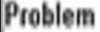

Result: 	 LFST99999999999999999999


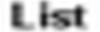

Result: 	 PROBLEM99999999999999999


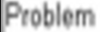

Result: 	 LAT999999999999999999999


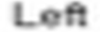

Result: 	 SHOULDER9999999999999999


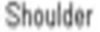

Result: 	 TIS999999999999999999999


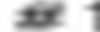

Result: 	 ADSES9999999999999999999


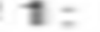

Result: 	 SHOULDER9999999999999999


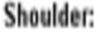

Result: 	 SCAPULAR9999999999999999


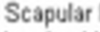

Result: 	 PAIN99999999999999999999


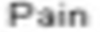

Result: 	 LEFR99999999999999999999


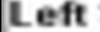

Result: 	 SHOULIDOR999999999999999


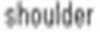

Result: 	 LOGRION99999999999999999


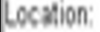

Result: 	 POSTENOR9999999999999999


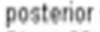

Result: 	 DRATIONS9999999999999999


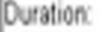

Result: 	 SRCE99999999999999999999


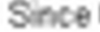

Result: 	 OPABREUT9999999999999999


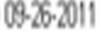

Result: 	 JORS99999999999999999999


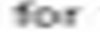

Result: 	 HSD999999999999999999999


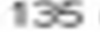

Result: 	 GAYSS999999999999999999


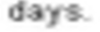

Result: 	 CAUTOR999999999999999999


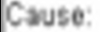

Result: 	 RESCHNG99999999999999999


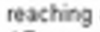

Result: 	 SHOULDER9999999999999999


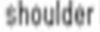

Result: 	 ECID99999999999999999999


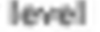

Result: 	 CATES9999999999999999999


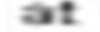

Result: 	 CKPAIN999999999999999999


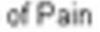

Result: 	 SEVENTY99999999999999999


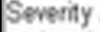

Result: 	 FRGURNCY9999999999999999


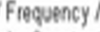

Result: 	 OUALKY999999999999999999


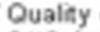

Result: 	 RAES99999999999999999999


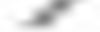

Result: 	 LERS99999999999999999999


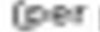

Result: 	 PATIENT99999999999999999


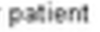

Result: 	 STO999999999999999999999


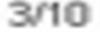

Result: 	 ESTENSLIONY9999999999999


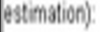

Result: 	 CONSTANT9999999999999999


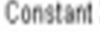

Result: 	 CUSHING99999999999999999


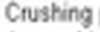

Result: 	 PAIR99999999999999999999


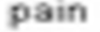

Result: 	 NATING999999999999999999


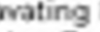

Result: 	 FACTORSR9999999999999999


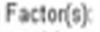

Result: 	 CETON9999999999999999999


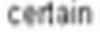

Result: 	 FEACHING9999999999999999


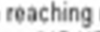

Result: 	 MOTIORS99999999999999999


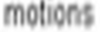

Result: 	 NSAOSH999999999999999999


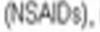

Result: 	 RELGING99999999999999999


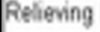

Result: 	 FACTONSH9999999999999999


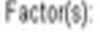

Result: 	 IMEORHIONS99999999999999


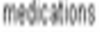

Result: 	 PACKE9999999999999999999


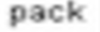

Result: 	 ED9999999999999999999999


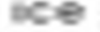

In [128]:
for _img in cropped_img2:
    recognize_img(_img)

### 3. 의사기준, EMR 차트 ocr 실험_2(eng)

In [123]:
IMG_PATH_emr2 = '/aiffel/aiffel/ocr2/emr_eng2_noise.png'


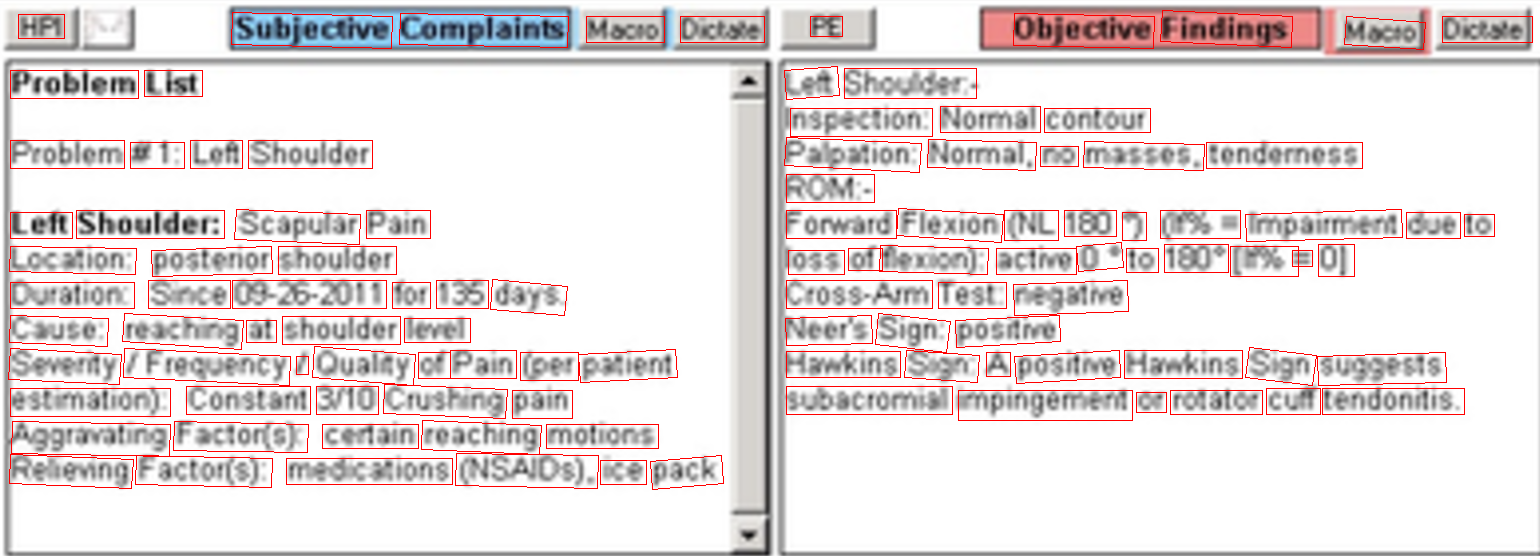

In [124]:
img_pil3, cropped_img3 = detect_text(IMG_PATH_emr2)
display(img_pil3)

Result: 	 HS9999999999999999999999


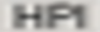

Result: 	 SUBIOCAIS999999999999999


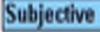

Result: 	 COMPLEINY999999999999999


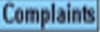

Result: 	 PNREINES9999999999999999


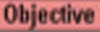

Result: 	 ARSS9999999999999999999


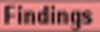

Result: 	 MCOL99999999999999999999


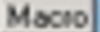

Result: 	 DICTSE999999999999999999


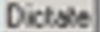

Result: 	 ES9999999999999999999999


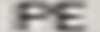

Result: 	 DICTSER99999999999999999


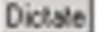

Result: 	 RKECHOS99999999999999999


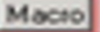

Result: 	 LEATE9999999999999999999


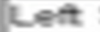

Result: 	 SHOUDETS9999999999999999


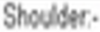

Result: 	 PROBLEM99999999999999999


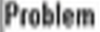

Result: 	 LFST99999999999999999999


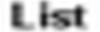

Result: 	 NORMAL999999999999999999


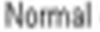

Result: 	 NSPECTION999999999999999


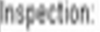

Result: 	 CONTOUR99999999999999999


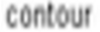

Result: 	 PULPATION999999999999999


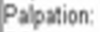

Result: 	 PROBLEM99999999999999999


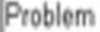

Result: 	 LAT999999999999999999999


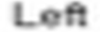

Result: 	 SHOULDOR9999999999999999


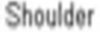

Result: 	 NORMAL999999999999999999


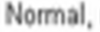

Result: 	 SLES99999999999999999999


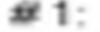

Result: 	 TENDERNOSS9999999999999


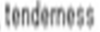

Result: 	 MATSES99999999999999999


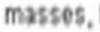

Result: 	 SRAND9999999999999999999


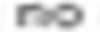

Result: 	 ROS999999999999999999999


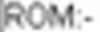

Result: 	 SHOULDER9999999999999999


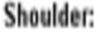

Result: 	 SCAPULSR9999999999999999


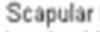

Result: 	 PAIN99999999999999999999


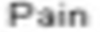

Result: 	 FORWARD99999999999999999


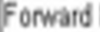

Result: 	 FLEXION99999999999999999


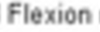

Result: 	 TALS99999999999999999999


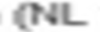

Result: 	 EAR999999999999999999999


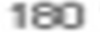

Result: 	 CAFS99999999999999999999


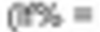

Result: 	 LEFR99999999999999999999


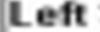

Result: 	 CHD999999999999999999999


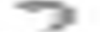

Result: 	 IMPOIMET999999999999999


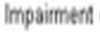

Result: 	 CSER99999999999999999999


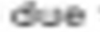

Result: 	 KACAS9999999999999999999


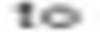

Result: 	 OAS999999999999999999999


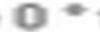

Result: 	 JEOS99999999999999999999


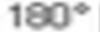

Result: 	 OADS99999999999999999999


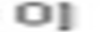

Result: 	 SHOULIDOR999999999999999


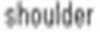

Result: 	 FERGNK999999999999999999


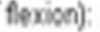

Result: 	 FAPES9999999999999999999


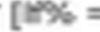

Result: 	 LOCTION99999999999999999


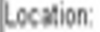

Result: 	 POSTENOR9999999999999999


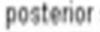

Result: 	 ACTES9999999999999999999


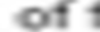

Result: 	 ACTRES999999999999999999


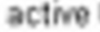

Result: 	 ATAORD999999999999999999


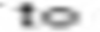

Result: 	 LOGIR9999999999999999999


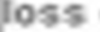

Result: 	 AES999999999999999999999


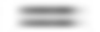

Result: 	 SRTE99999999999999999999


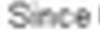

Result: 	 OSBRAUT99999999999999999


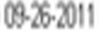

Result: 	 HS9999999999999999999999


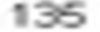

Result: 	 CROSSAM9999999999999999


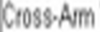

Result: 	 OUATIONT9999999999999999


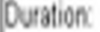

Result: 	 JORT99999999999999999999


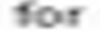

Result: 	 GAYS99999999999999999999


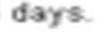

Result: 	 TESA99999999999999999999


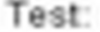

Result: 	 REGATHG99999999999999999


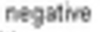

Result: 	 CAUTOR999999999999999999


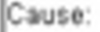

Result: 	 SHOULDER9999999999999999


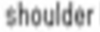

Result: 	 NEERS999999999999999999


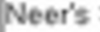

Result: 	 SIGNS9999999999999999999


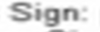

Result: 	 RESCHING9999999999999999


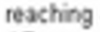

Result: 	 SECD99999999999999999999


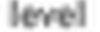

Result: 	 POSTHE999999999999999999


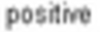

Result: 	 CATES9999999999999999999


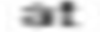

Result: 	 SEVERTY99999999999999999


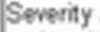

Result: 	 IFGRNCY99999999999999999


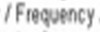

Result: 	 QUALKY999999999999999999


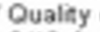

Result: 	 FPAIN9999999999999999999


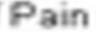

Result: 	 HIAKINS99999999999999999


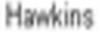

Result: 	 YSAGA9999999999999999999


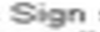

Result: 	 AOTN99999999999999999999


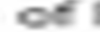

Result: 	 TRT999999999999999999999


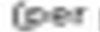

Result: 	 PATIENT99999999999999999


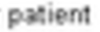

Result: 	 AMKINS999999999999999999


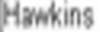

Result: 	 SAGS99999999999999999999


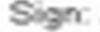

Result: 	 AD9999999999999999999999


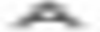

Result: 	 ARES99999999999999999999


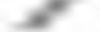

Result: 	 POSTNG999999999999999999


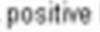

Result: 	 SUSESIS9999999999999999


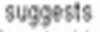

Result: 	 CONSTAN99999999999999999


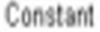

Result: 	 STO999999999999999999999


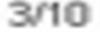

Result: 	 CUSHING99999999999999999


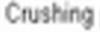

Result: 	 PUBOCRORMOL9999999999999


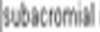

Result: 	 RSTENSLIONY9999999999999


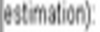

Result: 	 SCUTS9999999999999999999


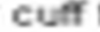

Result: 	 LENDONDIS999999999999999


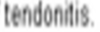

Result: 	 PAIR99999999999999999999


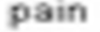

Result: 	 MPINGEREN999999999999999


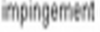

Result: 	 ROALCS999999999999999999


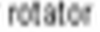

Result: 	 KLATE9999999999999999999


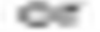

Result: 	 AGGIRATING9999999999999


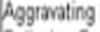

Result: 	 FACTORSR9999999999999999


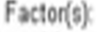

Result: 	 CEON99999999999999999999


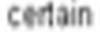

Result: 	 FEACHING9999999999999999


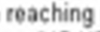

Result: 	 MOTIONS99999999999999999


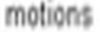

Result: 	 NSAOSH999999999999999999


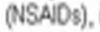

Result: 	 RELEING99999999999999999


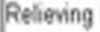

Result: 	 FACTONTST999999999999999


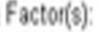

Result: 	 MESCARIONS99999999999999


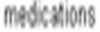

Result: 	 PACKH9999999999999999999


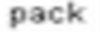

Result: 	 AKED99999999999999999999


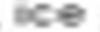

In [125]:
for _img in cropped_img3:
    recognize_img(_img)

### 4. 의사기준, EMR 차트 ocr 실험_3(kor)

In [76]:
IMG_PATH_emr3 = '/aiffel/aiffel/ocr2/emr_kor.png'


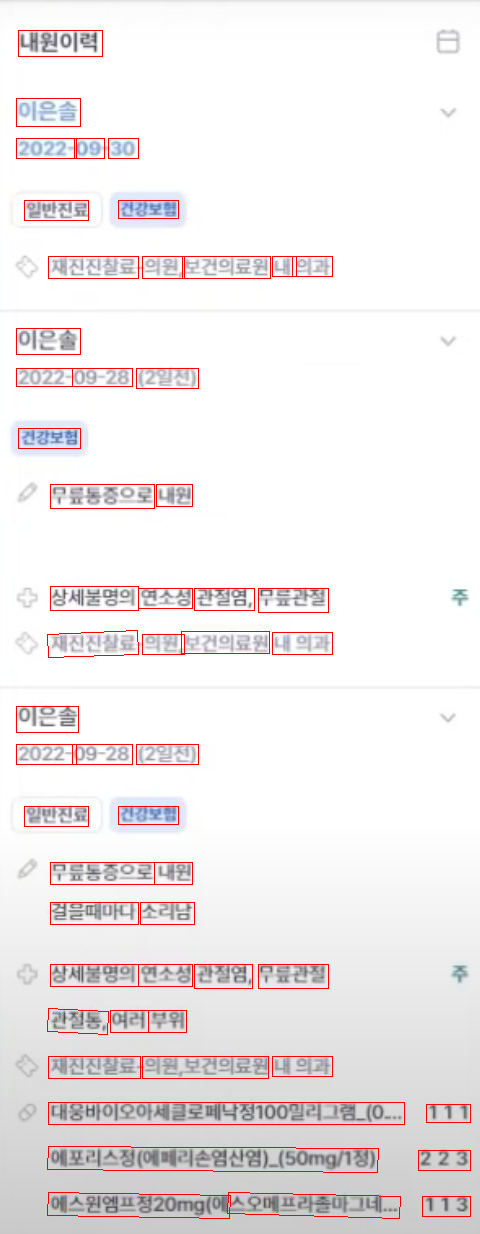

In [77]:
img_pil4, cropped_img4 = detect_text(IMG_PATH_emr3)
display(img_pil4)

Result: 	 LHOLES999999999999999999


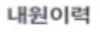

Result: 	 OLES99999999999999999999


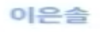

Result: 	 2OPS99999999999999999999


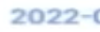

Result: 	 S99999999999999999999999


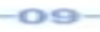

Result: 	 PD9999999999999999999999


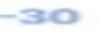

Result: 	 UKT999999999999999999999


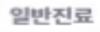

Result: 	 AES999999999999999999999


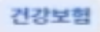

Result: 	 MRAE99999999999999999999


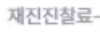

Result: 	 AT9999999999999999999999


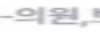

Result: 	 ARIOLEH99999999999999999


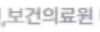

Result: 	 PAS999999999999999999999


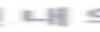

Result: 	 HSIAES999999999999999999


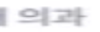

Result: 	 OLES99999999999999999999


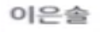

Result: 	 2OPA99999999999999999999


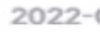

Result: 	 JOGADS999999999999999999


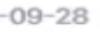

Result: 	 ZESY99999999999999999999


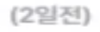

Result: 	 NAES99999999999999999999


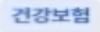

Result: 	 TRSOS9999999999999999999


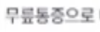

Result: 	 JLAES9999999999999999999


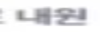

Result: 	 STMAEGON9999999999999999


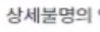

Result: 	 AS9999999999999999999999


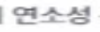

Result: 	 ELSAN9999999999999999999


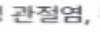

Result: 	 PIES99999999999999999999


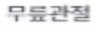

Result: 	 AERHAS999999999999999999


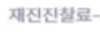

Result: 	 ARIOLAH99999999999999999


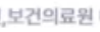

Result: 	 LASIAT999999999999999999


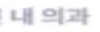

Result: 	 RAPAD9999999999999999999


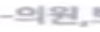

Result: 	 COLES9999999999999999999


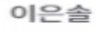

Result: 	 ZOPZI9999999999999999999


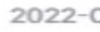

Result: 	 JOGRPS999999999999999999


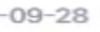

Result: 	 ZERY99999999999999999999


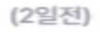

Result: 	 GUE999999999999999999999


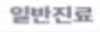

Result: 	 RES999999999999999999999


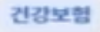

Result: 	 FRSSOE99999999999999999


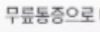

Result: 	 SAES99999999999999999999


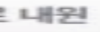

Result: 	 SEOIES999999999999999999


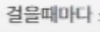

Result: 	 AELS99999999999999999999


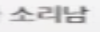

Result: 	 STMIAEGON999999999999999


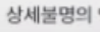

Result: 	 LES999999999999999999999


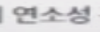

Result: 	 EIE999999999999999999999


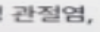

Result: 	 PAES99999999999999999999


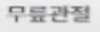

Result: 	 SEREBEN99999999999999999


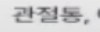

Result: 	 SOHELE999999999999999999


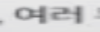

Result: 	 RATD99999999999999999999


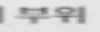

Result: 	 NADE99999999999999999999


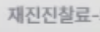

Result: 	 SHENOEH99999999999999999


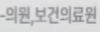

Result: 	 LHOAT9999999999999999999


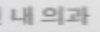

Result: 	 JGREDMERNGALL9999999999


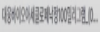

Result: 	 CTHD99999999999999999999


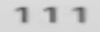

Result: 	 EHONERALSOIL999999999999


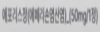

Result: 	 2ZS999999999999999999999


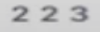

Result: 	 NEFGUYAINGIEL99999999999


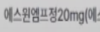

Result: 	 AOMERELIL999999999999999


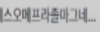

Result: 	 SHS999999999999999999999


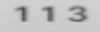

In [78]:
for _img in cropped_img4:
    recognize_img(_img)

In [129]:
# 추가실험 계획

# 기존 문자 집합(특수문자 포함)
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
SPECIAL_CHARACTERS = "!@#$%^&*()_-+=<>?/.,:;'\"[]{}|`~\\"

# 한글 음절 추가 (유니코드 범위: 가(AC00) ~ 힣(D7A3))
KOREAN_SYLLABLES = ''.join(chr(i) for i in range(0xAC00, 0xD7A4))

# 최종 문자 집합
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS + SPECIAL_CHARACTERS + KOREAN_SYLLABLES

# 문자 개수 출력
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 11240


## 회고
- ocr 모델을 만들때, detection과 recognization 두 과정을 각각 고려해야 한다는 것을 배우게 됐습니다.
- recognize 코드를 작성할때 어려움이 있었는데 팀원의 도움으로 잘 해결할 수 있었습니다. (동주님 감사합니다!!)
- 한국어 텍스트 또한 recognization이 잘 되는지 실험해보고 싶으며, CTC디코더를 변경하는 실험도 진행해 보고 싶습니다.(추후)
- 점점 어려워지는 프로젝트,,, 많이 노력해야할 것 같습니다.

## CRNN기반 모델 구성 및 학습 진행

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [17]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr2'

TRAIN_DATA_PATH = HOME_DIR+'/data2/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data2/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data2/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr2/data2/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


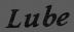

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


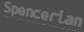

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


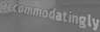

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


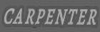

In [8]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [9]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


In [13]:
class LabelConverter(object):
    
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
             self.label_map[char] = i
    
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
             decoded_label += self.character[encode]
        return decoded_label
print("슝~")


슝~


In [14]:
# 아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 해보세요!
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [15]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [16]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


In [55]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [62]:
checkpoint_path = '/aiffel/aiffel/ocr2/best_ocr_model.keras'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',        # 'val_loss'를 기준으로 저장
    verbose=20,                 # 저장 시 출력
    save_best_only=True,       # 가장 좋은 모델만 저장
    mode='min',                # 손실이 최소화될 때 저장
    save_weights_only=False    # 전체 모델 저장 (구조 + 가중치)
)

# 모델 학습
history_ocr = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=20,                    # 최대 20 epoch
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[checkpoint]        # 콜백 추가
)

Epoch 1/20
565/565 [==============================] - 83s 146ms/step - loss: 14.9338 - val_loss: 9.9187

Epoch 00001: val_loss improved from inf to 9.91865, saving model to /aiffel/aiffel/ocr2/best_ocr_model.keras
Epoch 2/20
565/565 [==============================] - 84s 148ms/step - loss: 7.0926 - val_loss: 6.6352

Epoch 00002: val_loss improved from 9.91865 to 6.63517, saving model to /aiffel/aiffel/ocr2/best_ocr_model.keras
Epoch 3/20
565/565 [==============================] - 84s 148ms/step - loss: 5.1001 - val_loss: 5.4539

Epoch 00003: val_loss improved from 6.63517 to 5.45389, saving model to /aiffel/aiffel/ocr2/best_ocr_model.keras
Epoch 4/20
565/565 [==============================] - 84s 149ms/step - loss: 4.0500 - val_loss: 4.8271

Epoch 00004: val_loss improved from 5.45389 to 4.82713, saving model to /aiffel/aiffel/ocr2/best_ocr_model.keras
Epoch 5/20
565/565 [==============================] - 84s 148ms/step - loss: 3.3219 - val_loss: 4.4631

Epoch 00005: val_loss improved 

In [63]:
model.save_weights('/aiffel/aiffel/ocr2/ocr_model_weight.keras')

In [64]:
with open('history/history_ocr.json', 'w') as f:
    pd.DataFrame(history_ocr.history).to_json(f)

In [65]:
import os
# 현재 작업 디렉토리 확인
print("Current working directory:", os.getcwd())

Current working directory: /aiffel/aiffel/ocr2


In [66]:
# 저장된 history 파일 
import json
with open('history/history_ocr.json', 'r') as f:
    history_data = json.load(f)
history_df = pd.DataFrame(history_data)

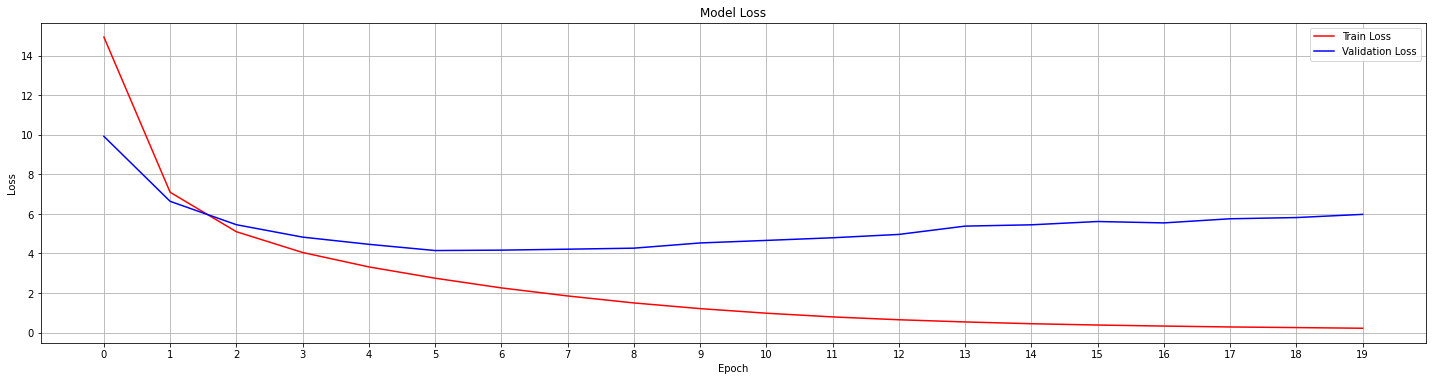

In [67]:
# 그래프 시각화
plt.figure(figsize=(20, 10))

# Loss 그래프
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째 그래프
plt.plot(history_df['loss'], 'r', label='Train Loss')
plt.plot(history_df['val_loss'], 'b', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

# # Accuracy 그래프 (history에 accuracy 값이 있는 경우)
# if 'accuracy' in history_df and 'val_accuracy' in history_df:
#     plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째 그래프
#     plt.plot(history_df['accuracy'], 'r', label='Train Accuracy')
#     plt.plot(history_df['val_accuracy'], 'b', label='Validation Accuracy')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#     plt.grid()

plt.tight_layout()
plt.show()

In [38]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = '/aiffel/aiffel/ocr2/data2/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


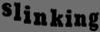

Result: 	 ALEPPO99999999999999999


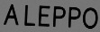

Result: 	 FWANDA999999999999999999


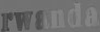

Result: 	 NATHANS99999999999999999


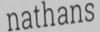

Result: 	 HALLE999999999999999999


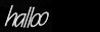

Result: 	 HURLS9999999999999999999


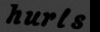

Result: 	 DOWNSIZE9999999999999999


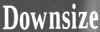

Result: 	 ROBOTIC99999999999999999


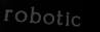

Result: 	 SLOPPY99999999999999999


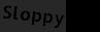

Result: 	 SHERMITE9999999999999999


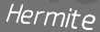

In [39]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)